In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)


engine.dispose()

In [2]:
housing_df.head(15)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [3]:
#Overview of columns
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [4]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Dealing with Missing Values

In [5]:
#Missing values
missing_values_count = housing_df.isnull().sum().sort_values(ascending=False)
missing_values_count

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
                 ... 
centralair          0
salecondition       0
heating             0
totalbsmtsf         0
id                  0
Length: 81, dtype: int64

In [6]:
#Percentage of missing values
missing_values_percent = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)
missing_values_percent

poolqc           0.995205
miscfeature      0.963014
alley            0.937671
fence            0.807534
fireplacequ      0.472603
                   ...   
centralair       0.000000
salecondition    0.000000
heating          0.000000
totalbsmtsf      0.000000
id               0.000000
Length: 81, dtype: float64

In [7]:
#Combine both count and percentage of missing values into a table
missing_values = pd.concat([missing_values_count, missing_values_percent], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


Of the 79 variables, 19 variables have missing values. Just looking at the missing variables, I can see a pattern emerging through some of the variables.  The variables about garages are missing the same number of variables (81) and the variables representing different basement factors are missing a similar number of variables (37 and 38).  <br><br>

So, I'm going to go through the variables systematically and see why values are missing.  Then, I will determine how to deal with the missing values.   

In [8]:
#Pool quality categories
housing_df.poolqc.unique()

array([None, 'Ex', 'Fa', 'Gd'], dtype=object)

In [9]:
#Poolqc is related to poolarea, so understanding this variable is helpful
housing_df.poolarea.unique()

array([  0, 512, 648, 576, 555, 480, 519, 738], dtype=int64)

In [10]:
#Exploring the nonzero values in pool area and the corresponding values in pool quality
pool_values = pd.concat([housing_df.poolarea, housing_df.poolqc], axis=1, keys=['Pool Area', 'Pool Quality'])
pool_values[pool_values['Pool Area'] != 0]

,Pool Area,Pool Quality
198,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd


All of the pool areas that have a value > 0 have a pool quality descriptor ('Ex', 'Fa', 'Gd').  All of the pool areas that have a value = 0 have a pool quality of None (since there is no pool).  Since pool area doesn't have any missing values, I'm going to change the None in pool quality to 'NP', which means no pool.   

In [11]:
# Want to change all the None values in Pool Quality to 'NP' since there is no pool
housing_df['poolqc'].fillna(value='NP', inplace = True)
housing_df.poolqc.head()

0    NP
1    NP
2    NP
3    NP
4    NP
Name: poolqc, dtype: object

In [12]:
#Missing variables in miscfeature column - missing 1406 variables
housing_df.miscfeature.unique()

array([None, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [13]:
#Exploring the relationship between miscfeature and miscvalue 
misc_columns = pd.concat([housing_df.miscval, housing_df.miscfeature], axis=1, keys=['Value', 'Feature'])
misc_columns.head()

,Value,Feature
0,0,None
1,0,None
2,0,None
3,0,None
4,0,None


In [14]:
misc_columns[misc_columns['Value'] != 0]

,Value,Feature
5,700,Shed
7,350,Shed
16,700,Shed
17,500,Shed
51,400,Shed
84,700,Shed
95,480,Shed
98,400,Shed
99,400,Shed
107,450,Shed


In [15]:
# Want to change all the None values in miscfeature to 'None' since all the rows with None just represent that there 
#are no miscfeatures in that house not necessarily missing data
housing_df['miscfeature'].fillna(value='None', inplace=True)
housing_df.miscfeature.head()

0    None
1    None
2    None
3    None
4    None
Name: miscfeature, dtype: object

In [16]:
#Missing variables in alley column - missing 1369 values
housing_df.alley.unique()

array([None, 'Grvl', 'Pave'], dtype=object)

In [17]:
#There are a lot of missing variables for alley and it looks like all the None variables may represent true missing data.
#Going to change all the missing values to 'UNK' for unknown

housing_df['alley'].fillna(value='UNK', inplace=True)

In [18]:
#Missing variables in fence column - missing 1179 values
housing_df.fence.unique()

array([None, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [19]:
#There are a lot of missing variables for fence and it looks like all the None variables may represent true missing data.
#Going to change all the missing values to 'UNK' for unknown
housing_df['fence'].fillna(value='UNK', inplace=True)

In [20]:
#Missing variables in fireplacequ column - missing 690 values
housing_df.fireplacequ.unique()

array([None, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [21]:
#Exploring fireplaces column that shows number of fireplaces a house has
housing_df.fireplaces.unique()

array([0, 1, 2, 3], dtype=int64)

In [22]:
#Since the fireplacequ relies on the presence of a fireplace, I want to explore if all the None variables correspond
#with all of rows where the fireplace value equals 0
fireplace_columns = pd.concat([housing_df.fireplaces, housing_df.fireplacequ], axis=1, keys=['# of FP', 'Quality'])
fireplace_columns.head()

,# of FP,Quality
0,0,None
1,1,TA
2,1,TA
3,1,Gd
4,1,TA


In [23]:
fireplace_columns[fireplace_columns['# of FP'] == 0]

,# of FP,Quality
0,0,None
5,0,None
10,0,None
12,0,None
15,0,None
17,0,None
18,0,None
19,0,None
26,0,None
29,0,None


In [24]:
fireplace_columns[fireplace_columns['# of FP'] != 0]

,# of FP,Quality
1,1,TA
2,1,TA
3,1,Gd
4,1,TA
6,1,Gd
7,2,TA
8,2,TA
9,2,TA
11,2,Gd
13,1,Gd


In [25]:
#All of the missing values for fireplacequ stem from houses with no fireplaces.  Going to change None to 'NoFP' to 
#indicate that a fireplace quality cannot be given for a house that doesn't have a fireplace
housing_df['fireplacequ'].fillna(value='NoFP', inplace = True)
housing_df.fireplacequ.head()

0    NoFP
1      TA
2      TA
3      Gd
4      TA
Name: fireplacequ, dtype: object

In [26]:
#Missing variables in lotfrontage column (Linear feet of street connected to property) - 259 missing values
housing_df.lotfrontage.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

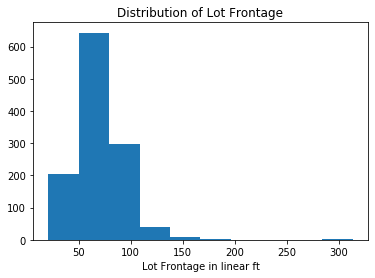

70.04995836802665
69.0
0    60.0
dtype: float64


In [27]:
#Distribution of lotfrontage with histogram
plt.hist(housing_df.lotfrontage)
plt.xlabel('Lot Frontage in linear ft')
plt.title('Distribution of Lot Frontage')
plt.show()

print(housing_df.lotfrontage.mean())
print(housing_df.lotfrontage.median())
print(housing_df.lotfrontage.mode())

Since all three measure of central tendency are the same, I will use the mean to impute the missing values. 

In [28]:
#Using imputation to fill in missing numbers with the mean
housing_df.lotfrontage.fillna(housing_df.lotfrontage.mean(), inplace=True)

In [29]:
#There are five columns dealing with garage descriptors that are missing the same amount of variables, going to explore
#them all together before deciding how to deal with the missing data

#Missing variables in garagetype column - missing 81 values
housing_df.garagetype.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', None, 'Basment',
       '2Types'], dtype=object)

In [30]:
#Missing variables in garageyrblt column - missing 81 values
housing_df.garageyrblt.unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

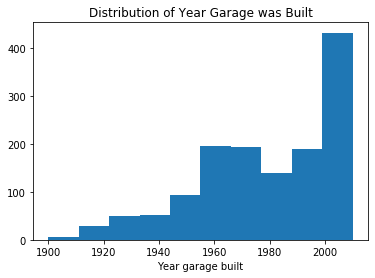

1978.5061638868744
1980.0
0    2005.0
dtype: float64


In [31]:
plt.hist(housing_df.garageyrblt)
plt.xlabel('Year garage built')
plt.title('Distribution of Year Garage was Built')
plt.show()

print(housing_df.garageyrblt.mean())
print(housing_df.garageyrblt.median())
print(housing_df.garageyrblt.mode())

Since the mean, median, and mode have negligible differences, I will use imputation with the mean to fill in the null values. 

In [32]:
#Replace missing values with mean 
housing_df.garageyrblt.fillna(housing_df.garageyrblt.mean(), inplace=True)

In [33]:
#Missing variables in garagefinish column - missing 81 values
housing_df.garagefinish.unique()

array(['RFn', 'Unf', 'Fin', None], dtype=object)

In [34]:
#Missing variables in garagequal column - missing 81 values
housing_df.garagequal.unique()

array(['TA', 'Fa', 'Gd', None, 'Ex', 'Po'], dtype=object)

In [35]:
#Missing variables in garagecond column - missing 81 values
housing_df.garagecond.unique()

array(['TA', 'Fa', None, 'Gd', 'Po', 'Ex'], dtype=object)

In [36]:
#Exploring all columns together with garagearea column which has no missing values to see if there is a pattern
garage_columns = pd.concat([housing_df.garagearea, housing_df.garagetype, housing_df.garageyrblt, housing_df.garagefinish, housing_df.garagequal,
                           housing_df.garagecond], axis=1, keys=['Area','Type', 'Yr Built', 'Finish', 'Quality', 'Condition'])
garage_columns

,Area,Type,Yr Built,Finish,Quality,Condition
0,548,Attchd,2003.000000,RFn,TA,TA
1,460,Attchd,1976.000000,RFn,TA,TA
2,608,Attchd,2001.000000,RFn,TA,TA
3,642,Detchd,1998.000000,Unf,TA,TA
4,836,Attchd,2000.000000,RFn,TA,TA
5,480,Attchd,1993.000000,Unf,TA,TA
6,636,Attchd,2004.000000,RFn,TA,TA
7,484,Attchd,1973.000000,RFn,TA,TA
8,468,Detchd,1931.000000,Unf,Fa,TA
9,205,Attchd,1939.000000,RFn,Gd,TA


In [37]:
#Only showing the rows where garage area equals 0
garage_columns[garage_columns['Area'] == 0]

,Area,Type,Yr Built,Finish,Quality,Condition
39,0,None,1978.506164,None,None,None
48,0,None,1978.506164,None,None,None
78,0,None,1978.506164,None,None,None
88,0,None,1978.506164,None,None,None
89,0,None,1978.506164,None,None,None
99,0,None,1978.506164,None,None,None
100,0,None,1978.506164,None,None,None
109,0,None,1978.506164,None,None,None
126,0,None,1978.506164,None,None,None
128,0,None,1978.506164,None,None,None


In [38]:
#Since all 81 of the missing variables in the 5 garage columns correspond to a garagearea of 0, it means that the data is not
#missing - there is just no data for these particular instances.  Going to change all categorical variables from Nones 
#to 'NG' for no garage 
housing_df['garagetype'].fillna(value='NG', inplace = True)
housing_df['garagefinish'].fillna(value='NG', inplace = True)
housing_df['garagequal'].fillna(value='NG', inplace = True)
housing_df['garagecond'].fillna(value='NG', inplace = True)


In [39]:
#Like with the garage columns, there are five columns dealing with basement descriptors that are missing the same amount 
#of variables, going to explore them all together before deciding how to deal with the missing data

#Missing variables in bsmtexposure column - missing 38 values
housing_df.bsmtexposure.unique()

array(['No', 'Gd', 'Mn', 'Av', None], dtype=object)

In [40]:
#Missing variables in bsmtfintype2 column - missing 38 values
housing_df.bsmtfintype2.unique()

array(['Unf', 'BLQ', None, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

In [41]:
#Missing variables in bsmtfintype1 column - missing 37 values
housing_df.bsmtfintype1.unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', None, 'LwQ'], dtype=object)

In [42]:
#Missing variables in bsmtcond column - missing 37 values
housing_df.bsmtcond.unique()

array(['TA', 'Gd', None, 'Fa', 'Po'], dtype=object)

In [43]:
#Missing variables in bsmtqual column - missing 37 values
housing_df.bsmtqual.unique()

array(['Gd', 'TA', 'Ex', None, 'Fa'], dtype=object)

In [44]:
#Exploring all columns together with totalbsmtsf column which has no missing values to see if there is a pattern
bsmt_columns = pd.concat([housing_df.totalbsmtsf,housing_df.bsmtexposure, housing_df.bsmtfintype2, housing_df.bsmtfintype1, 
                          housing_df.bsmtcond, housing_df.bsmtqual], axis=1, keys=['SF','Exposure', 'FinType2', 'FinType1',
                                                                                   'Condition', 'Quality'])

bsmt_columns

,SF,Exposure,FinType2,FinType1,Condition,Quality
0,856,No,Unf,GLQ,TA,Gd
1,1262,Gd,Unf,ALQ,TA,Gd
2,920,Mn,Unf,GLQ,TA,Gd
3,756,No,Unf,ALQ,Gd,TA
4,1145,Av,Unf,GLQ,TA,Gd
5,796,No,Unf,GLQ,TA,Gd
6,1686,Av,Unf,GLQ,TA,Ex
7,1107,Mn,BLQ,ALQ,TA,Gd
8,952,No,Unf,Unf,TA,TA
9,991,No,Unf,GLQ,TA,TA


In [45]:
#Only showing the rows where bsmt SF equals 0
bsmt_columns[bsmt_columns['SF'] == 0]

,SF,Exposure,FinType2,FinType1,Condition,Quality
17,0,None,None,None,None,None
39,0,None,None,None,None,None
90,0,None,None,None,None,None
100,0,None,None,None,None,None
103,0,None,None,None,None,None
157,0,None,None,None,None,None
183,0,None,None,None,None,None
260,0,None,None,None,None,None
343,0,None,None,None,None,None
363,0,None,None,None,None,None


In [46]:
#Since all 37/38 of the missing variables in the 5 basement columns correspond to a SF of 0, it means that the data is not
#missing - there is just no data for these particular instances.  Going to change all categorical variables from Nones 
#to 'NB' for no basement.
housing_df['bsmtexposure'].fillna(value='NB', inplace = True)
housing_df['bsmtfintype2'].fillna(value='NB', inplace = True)
housing_df['bsmtfintype1'].fillna(value='NB', inplace = True)
housing_df['bsmtcond'].fillna(value='NB', inplace = True)
housing_df['bsmtqual'].fillna(value='NB', inplace = True)

In [47]:
#Missing variables in masvnrarea column - missing 8 values
housing_df.masvnrarea.unique()

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

In [48]:
#Missing variables in masvrntype column - missing 37 values
housing_df.masvnrtype.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', None], dtype=object)

In [49]:
#Exploring both masvnr columns together to see if the missing values have a pattern (Masonry veener type and area)
mas_columns = pd.concat([housing_df.masvnrarea,housing_df.masvnrtype], axis=1, keys=['Area', 'Type'])

mas_columns

,Area,Type
0,196.0,BrkFace
1,0.0,None
2,162.0,BrkFace
3,0.0,None
4,350.0,BrkFace
5,0.0,None
6,186.0,Stone
7,240.0,Stone
8,0.0,None
9,0.0,None


In [50]:
#Exploring all Null values
null_columns=mas_columns.columns[mas_columns.isnull().any()]
print(mas_columns[mas_columns.isnull().any(axis=1)][null_columns].head())

     Area  Type
235   NaN  None
529   NaN  None
650   NaN  None
936   NaN  None
973   NaN  None


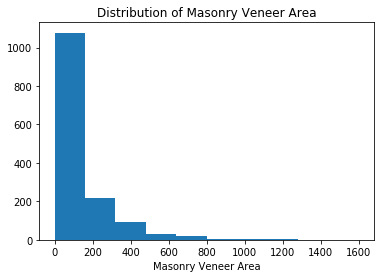

103.68526170798899
0.0
0    0.0
dtype: float64


In [51]:
#Exploring imputation options via distribution
plt.hist(housing_df.masvnrarea)
plt.xlabel('Masonry Veneer Area')
plt.title('Distribution of Masonry Veneer Area')
plt.show()

print(housing_df.masvnrarea.mean())
print(housing_df.masvnrarea.median())
print(housing_df.masvnrarea.mode())

Since the distribution of masvnrarea is right skewed, I don't think the mean would be the best value to replace the null values.  Since the median and mode are both 0, I'm going to replace the null values with 0. 

In [52]:
#For the missing values in masvnrarea, I'm going to replace the null values with 0, which is the most common value
#For the missing values in masvnrtype, I'm going to replace the null values to 'None' for the type since all the 
#corresponding masvnrarea null values were replaced with 0
housing_df.masvnrarea.fillna(value=0, inplace=True)
housing_df.masvnrtype.fillna(value='None', inplace=True)

In [53]:
#Missing variables in electrical column - missing 1 value
housing_df.electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', None], dtype=object)

In [54]:
elec_col = pd.concat([housing_df.electrical], axis=1, keys=['Electrical'])
null_columns=elec_col.columns[elec_col.isnull().any()]
elec_col[elec_col.isnull().any(axis=1)][null_columns].head()

,Electrical
1379,None


In [55]:
#Going to change missing value to 'UNK' for unknown 
housing_df['electrical'].fillna(value='UNK', inplace = True)

In [56]:
missing_values_count = housing_df.isnull().sum().sort_values(ascending=False)
missing_values_count.head(5)

saleprice      0
heating        0
roofstyle      0
roofmatl       0
exterior1st    0
dtype: int64

All missing data has been dealt with. <br><br>

### Exploratory  Data Analysis

In [57]:
#Categorical variable columns

categorical_variables = housing_df.select_dtypes(['object']).columns
categorical_variables

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

In [58]:
#Continuous variable columns

continuous_variables = housing_df.select_dtypes(['int64', 'float64']).columns
continuous_variables

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

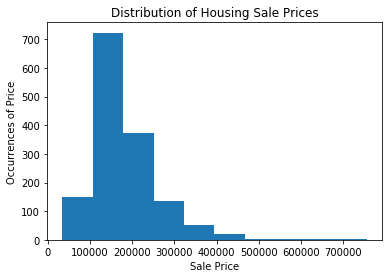

Mean: 180921.19589041095
Median: 163000.0
Mode: 0    140000
dtype: int64


In [59]:
#Exploratory analysis
#Histogram of target variable - sale price
plt.hist(housing_df.saleprice)
plt.xlabel('Sale Price')
plt.ylabel('Occurrences of Price')
plt.title('Distribution of Housing Sale Prices')

plt.show()

print('Mean: {}'.format(housing_df.saleprice.mean()))
print('Median: {}'.format(housing_df.saleprice.median()))
print('Mode: {}'.format(housing_df.saleprice.mode()))

The sale price has a skewed distribution.  As there is are higher occurrences of lower sales price and less occurrences of larger sale prices, the distribution is skewed right.  

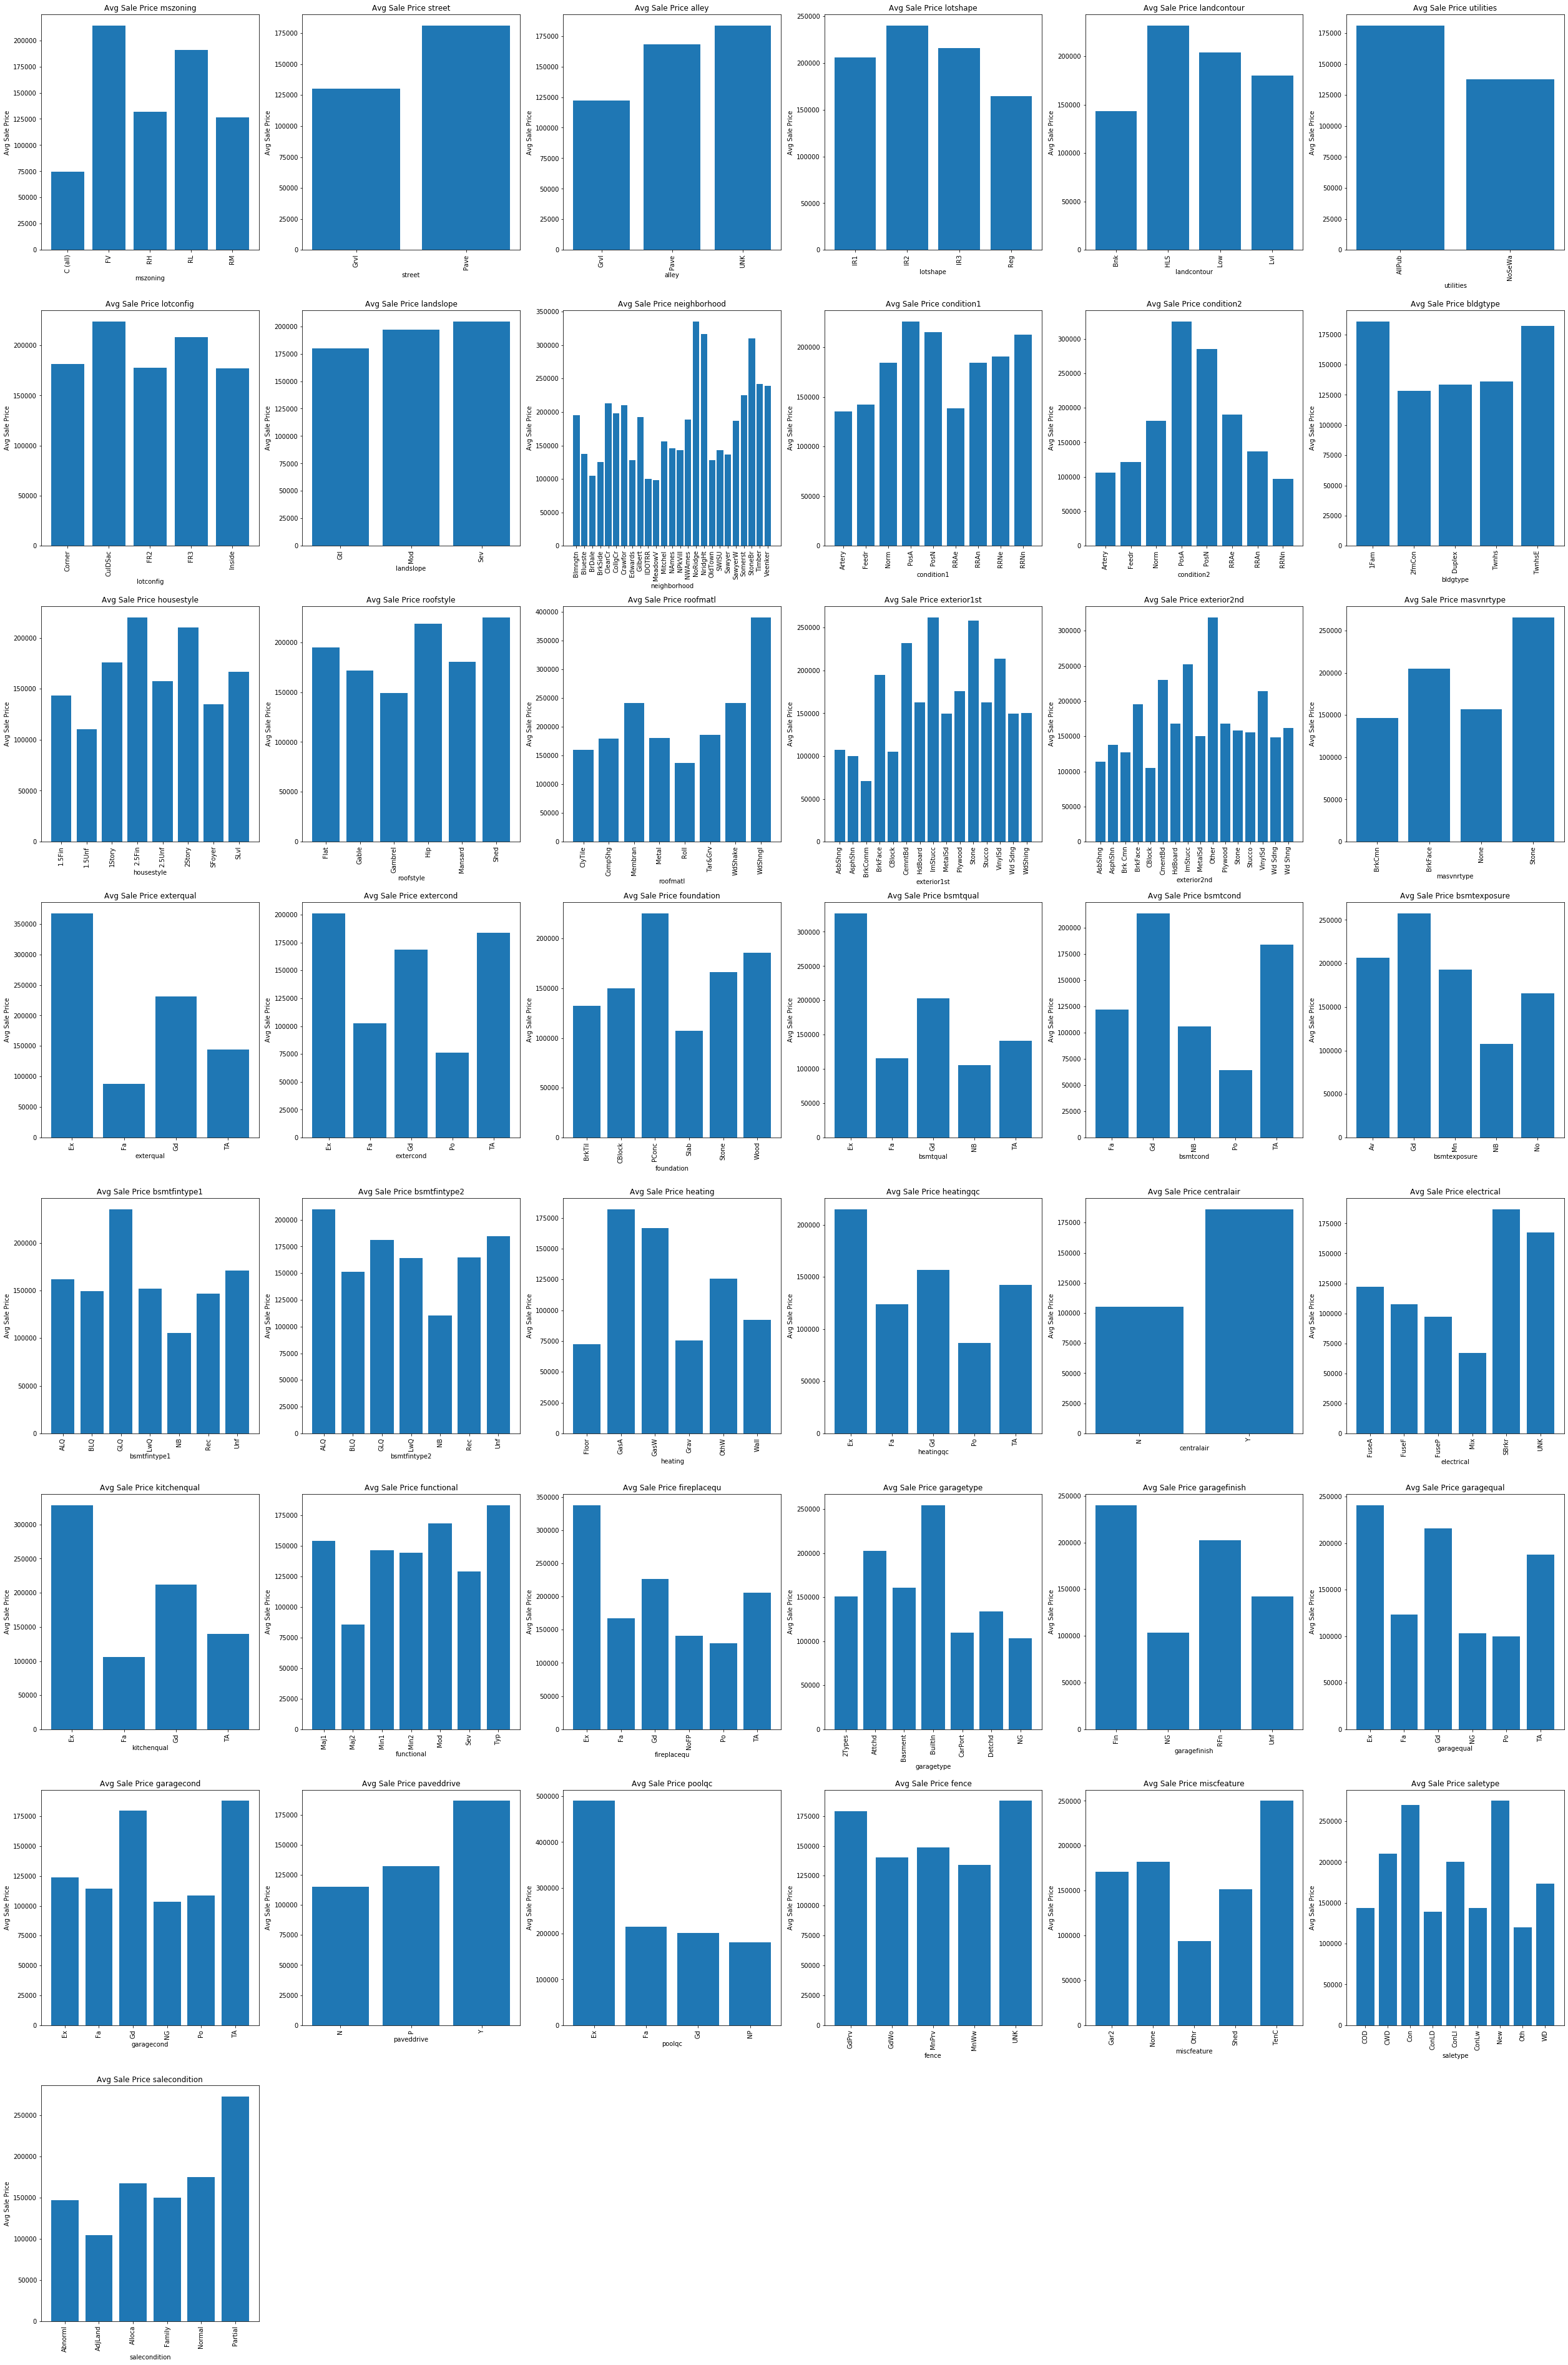

In [60]:
#Bar plots show the relationship between sale price (target variable) and categorical variables

categorical_variables = housing_df.select_dtypes(['object']).columns

plt.figure(figsize=(35, 65))
for i, col in enumerate(categorical_variables):
    plt.subplot(10,6,i+1)
    plt.bar(housing_df.groupby(col)['saleprice'].mean().index, housing_df.groupby(col)['saleprice'].mean())
    plt.title('Avg Sale Price ' + categorical_variables[i])
    plt.ylabel('Avg Sale Price')
    plt.xlabel(col)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [61]:
#Correlations of variables
continuous_variables = housing_df.select_dtypes(['int64', 'float64']).columns

housing_df[continuous_variables].corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
id,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
mssubclass,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
lotfrontage,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.178699,0.215828,...,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768,0.334901
lotarea,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
overallqual,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
overallcond,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
yearbuilt,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
yearremodadd,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
masvnrarea,-0.051071,0.023573,0.178699,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,...,0.159991,0.122528,-0.109907,0.019144,0.062248,0.011928,-0.029512,-0.006723,-0.008317,0.472614
bsmtfinsf1,-0.005024,-0.069836,0.215828,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [62]:
#Correlation between target variable and continuous variable
(housing_df[continuous_variables].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
masvnrarea       0.472614
garageyrblt      0.470177
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.334901
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

### Creating Regression Models

I am running two models - one with features exclusively from the housing prices data set and a second model with the same features as the first model but will add external data. 

#### Model 1: No external data

After looking at the exploratory analysis, I'm going to choose 39 features total - 6 continuous, 31 categorical, and 2 interaction terms. <br>

The continuous variables will be overallqual (Overall Quality - overall building and material quality), grlivearea (GrLivArea - above grade (ground) living area square feet), garagecars(Garage Cars - size of garage in car capacity), garagearea, totalbsmtsf, firstflrsf, and secondflrsf. Interaction terms of overall quality and year built, as well overall quality and square footage of the basement, first floor, and second floor are included.  <br>

The categorical variables will be neighborhood, exterqual(Exterior material quality), and mszoning because those features show variability. Breaking them up into dummy variables creates 31 different features.   

In [63]:
#Create dummies for the categorical features
housing_df = pd.get_dummies(housing_df, columns=['exterqual', 'neighborhood', 'mszoning'], drop_first=True)

In [64]:
#Creating variable for all dummy columns
dummy_columns = ['exterqual_Fa', 'exterqual_Gd','exterqual_TA', 'neighborhood_Blueste',
'neighborhood_BrDale', 'neighborhood_BrkSide', 'neighborhood_ClearCr',
'neighborhood_CollgCr', 'neighborhood_Crawfor', 'neighborhood_Edwards',
'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV',
'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill',
'neighborhood_NWAmes', 'neighborhood_NoRidge', 'neighborhood_NridgHt',
'neighborhood_OldTown', 'neighborhood_SWISU', 'neighborhood_Sawyer',
'neighborhood_SawyerW', 'neighborhood_Somerst', 'neighborhood_StoneBr',
'neighborhood_Timber', 'neighborhood_Veenker', 'mszoning_FV',
'mszoning_RH', 'mszoning_RL', 'mszoning_RM']

In [65]:
#Create interaction terms
housing_df['interaction_overallqual_sf'] = housing_df.overallqual * (housing_df.totalbsmtsf + housing_df.firstflrsf + housing_df.secondflrsf)
housing_df['interaction_overallqual_yrbuilt'] = housing_df.overallqual * housing_df.yearbuilt


In [66]:
#Setting variables for model
X = housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 
                'interaction_overallqual_yrbuilt', 'interaction_overallqual_sf'] + dummy_columns]
Y = housing_df.saleprice

In [67]:
#Splitting data into train/test sets and setting alpha levels (lambda)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


In [68]:
#OLS

lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8181459984370967
-----Test set statistics-----
R-squared of the model in the test set is: 0.8411188385155551
Mean absolute error of the prediction is: 21412.253035821843
Mean squared error of the prediction is: 1058218252.8801483
Root mean squared error of the prediction is: 32530.266720089283
Mean absolute percentage error of the prediction is: 12.250565198691652


In [69]:
#Ridge

ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8181459984370968
-----Test set statistics-----
R-squared of the model on the test set is: 0.8411188385155021
Mean absolute error of the prediction is: 21412.253035827165
Mean squared error of the prediction is: 1058218252.8805015
Root mean squared error of the prediction is: 32530.26672009471
Mean absolute percentage error of the prediction is: 12.250565198689472


In [70]:
#Lasso

lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8179106550912866
-----Test set statistics-----
R-squared of the model on the test set is: 0.8395756218723269
Mean absolute error of the prediction is: 21474.031005237488
Mean squared error of the prediction is: 1068496752.8908142
Root mean squared error of the prediction is: 32687.868588985948
Mean absolute percentage error of the prediction is: 12.276575878749577


In [71]:
#ElasticNet

elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8178992392165062
-----Test set statistics-----
R-squared of the model on the test set is: 0.8396205701962578
Mean absolute error of the prediction is: 21475.25364214349
Mean squared error of the prediction is: 1068197377.3300138
Root mean squared error of the prediction is: 32683.28896133334
Mean absolute percentage error of the prediction is: 12.276184047212856


#### Evaluting the tests

##### OLS Model
R-squared of the model in the training set is: 0.8181459984370967 <br>
-----Test set statistics-----  <br>
R-squared of the model in the test set is: 0.8411188385155551 <br>
Mean absolute error of the prediction is: 21412.253035821843 <br>
Mean squared error of the prediction is: 1058218252.8801483 <br>
Root mean squared error of the prediction is: 32530.266720089283 <br>
Mean absolute percentage error of the prediction is: 12.250565198691652 <br> <br>

##### Ridge Model
R-squared of the model on the training set is: 0.8181459984370968 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8411188385155021 <br>
Mean absolute error of the prediction is: 21412.253035827165  <br>
Mean squared error of the prediction is: 1058218252.8805015 <br>
Root mean squared error of the prediction is: 32530.26672009471 <br>
Mean absolute percentage error of the prediction is: 12.250565198689472 <br>

##### Lasso Model
R-squared of the model on the training set is: 0.8179106550912866 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8395756218723269 <br>
Mean absolute error of the prediction is: 21474.031005237488 <br>
Mean squared error of the prediction is: 1068496752.8908142 <br>
Root mean squared error of the prediction is: 32687.868588985948 <br>
Mean absolute percentage error of the prediction is: 12.276575878749577 <br>

##### ElasticNet Model
R-squared of the model on the training set is: 0.8178992392165062 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8396205701962578 <br>
Mean absolute error of the prediction is: 21475.25364214349 <br>
Mean squared error of the prediction is: 1068197377.3300138 <br>
Root mean squared error of the prediction is: 32683.28896133334 <br>
Mean absolute percentage error of the prediction is: 12.276184047212856 <br> <br>

The OLS and Ridge models are the best.  They both are very similar in their evaluation metrics.  The R-squared values for both the training and test sets have neglible differences (approx. 0.0000000000000001 and 0.0000000000000530 differences in R-squared, respectively).  The error evaluation metrics reflect the same neglible differences.

#### Model 2: Using avg annual mortgage yearly interest rates as external data

I am adding in the avg annual mortgage interest rates during the years that the houses sold as external data.  Since I am using the same features as above, and the only difference the addition of the interest rates, I can compare both models to determine how the external data affected the performance.  

In [72]:
#Exploring yrsold variable to know what years I need to get interest rates for
housing_df.yrsold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

I am adding in avg annual mortage interest rates for 30-year fixed mortgages for 2005 through 2010.  There are different types and lengths of mortgages, but I went with the most common type and length.  I got this historical mortgage information from freddiemac.com at http://www.freddiemac.com/pmms/pmms30.html.

In [73]:
#Creating dataframe of interest rates 
interest_rates = {'int_rates': [5.87, 6.41, 6.34, 6.03, 5.04, 4.69], 'yrsold': [2005, 2006, 2007, 2008, 2009, 2010]}
housing_df2 = pd.DataFrame(interest_rates)
housing_df2.head(6)

,int_rates,yrsold
0,5.87,2005
1,6.41,2006
2,6.34,2007
3,6.03,2008
4,5.04,2009
5,4.69,2010


In [74]:
#Merging dataframes with an inner join on yrsold
housing_df = pd.merge(housing_df, housing_df2, on='yrsold', how='inner')

In [75]:
#Correlation between target variable and continuous variable with interest rates
continuous_variables = housing_df.select_dtypes(['int64', 'float64']).columns
(housing_df[continuous_variables].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice                          1.000000
interaction_overallqual_sf         0.856148
interaction_overallqual_yrbuilt    0.796232
overallqual                        0.790982
grlivarea                          0.708624
garagecars                         0.640409
garagearea                         0.623431
totalbsmtsf                        0.613581
firstflrsf                         0.605852
fullbath                           0.560664
totrmsabvgrd                       0.533723
yearbuilt                          0.522897
yearremodadd                       0.507101
masvnrarea                         0.472614
garageyrblt                        0.470177
fireplaces                         0.466929
bsmtfinsf1                         0.386420
lotfrontage                        0.334901
wooddecksf                         0.324413
secondflrsf                        0.319334
openporchsf                        0.315856
halfbath                           0.284108
lotarea                         

In [76]:
#Setting variables for model - adding int_rates
X = housing_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 
                'interaction_overallqual_yrbuilt', 'interaction_overallqual_sf', 'int_rates'] + dummy_columns]
Y = housing_df.saleprice

In [77]:
#Splitting data into train/test sets and setting alpha levels (lambda)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 17)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


In [78]:
#OLS

lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8201279800373827
-----Test set statistics-----
R-squared of the model in the test set is: 0.8292399299317661
Mean absolute error of the prediction is: 21335.56461228365
Mean squared error of the prediction is: 1153437048.236023
Root mean squared error of the prediction is: 33962.288618937666
Mean absolute percentage error of the prediction is: 11.961890221728172


In [79]:
#Ridge

ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7135184071758587
-----Test set statistics-----
R-squared of the model on the test set is: 0.8154444669918522
Mean absolute error of the prediction is: 23643.669007914243
Mean squared error of the prediction is: 1246621585.1485772
Root mean squared error of the prediction is: 35307.528731824
Mean absolute percentage error of the prediction is: 14.233762815664482


In [80]:
#Lasso

lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.6789017847120488
-----Test set statistics-----
R-squared of the model on the test set is: 0.7833212950261712
Mean absolute error of the prediction is: 25258.94963687178
Mean squared error of the prediction is: 1463604727.8544073
Root mean squared error of the prediction is: 38257.08728921227
Mean absolute percentage error of the prediction is: 15.365182395092658


In [81]:
#ElasticNet

elasticregr = ElasticNetCV(alphas=alphas, cv=5)
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.7173215473546439
-----Test set statistics-----
R-squared of the model on the test set is: 0.8238941557847443
Mean absolute error of the prediction is: 23297.397307265033
Mean squared error of the prediction is: 1189546274.1821897
Root mean squared error of the prediction is: 34489.799567150134
Mean absolute percentage error of the prediction is: 14.035585088241348


#### Evaluting the tests

##### OLS Model <br>
R-squared of the model in the training set is: 0.8201279800373827 <br>
-----Test set statistics----- <br>
R-squared of the model in the test set is: 0.8292399299317661 <br>
Mean absolute error of the prediction is: 21335.56461228365 <br>
Mean squared error of the prediction is: 1153437048.236023 <br>
Root mean squared error of the prediction is: 33962.288618937666 <br>
Mean absolute percentage error of the prediction is: 11.961890221728172 <br> <br>

##### Ridge Model <br>
R-squared of the model on the training set is: 0.7135184071758587 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8154444669918522 <br>
Mean absolute error of the prediction is: 23643.669007914243 <br>
Mean squared error of the prediction is: 1246621585.1485772 <br>
Root mean squared error of the prediction is: 35307.528731824 <br>
Mean absolute percentage error of the prediction is: 14.233762815664482 <br> <br>

##### Lasso Model <br>
R-squared of the model on the training set is: 0.6789017847120488 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.7833212950261712 <br>
Mean absolute error of the prediction is: 25258.94963687178 <br>
Mean squared error of the prediction is: 1463604727.8544073 <br>
Root mean squared error of the prediction is: 38257.08728921227 <br>
Mean absolute percentage error of the prediction is: 15.365182395092658 <br> <br>

##### ElasticNet Model <br>
R-squared of the model on the training set is: 0.7173215473546439 <br>
-----Test set statistics----- <br>
R-squared of the model on the test set is: 0.8238941557847443 <br>
Mean absolute error of the prediction is: 23297.397307265033 <br>
Mean squared error of the prediction is: 1189546274.1821897 <br>
Root mean squared error of the prediction is: 34489.799567150134 <br>
Mean absolute percentage error of the prediction is: 14.035585088241348 <br> <br>

OLS outperformed every other model on the training set.  OLS also performed the best on the test set, but there were less differences between the performance of the other models in the test set compared to differences in the training set (in R-squared values).  All of the error evaluation metrics are the smallest for OLS. <br><br>

### Model Comparison

Adding in the interest rates as an external source of data changed the performance of the Model 2 models in several ways.  First, there are larger differences within each model's training and test set R-squared metrics, as well as more variation between the training and test set metrics of each of the models.  In other words, in the models with the external data, the test sets have over a.10 point increase in their performances compared to the training sets.  Also, in Model 1 all of the models had evaluation metrics that were comparable in performance.  But in Model 2, all the models show more variability in performance compared to each other.  

Additionally, every model in Model 1 outperformed every model in Model 2 in the majority of R-squared and error evaluation metrics.  The addition of interest rates as external data did not improve on the performance of Model 1. 

Interest rates had a low correlation rate of 0.026637 with sale price.  I would not have included this feature in Model 1 had it been present in the original dataset.   